<a href="https://colab.research.google.com/github/tleitch/Machine-Learning-for-Algorithmic-Trading-Second-Edition/blob/master/assignments/projectOptimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inputs
There are 3 ways to input. 

First, you can save strategy returns in a direrctory names "projects", namely, the path is /content/drive/MyDrive/ahfs/project . The sma.ipynb atomatically saves to this folder.

Second, the codse below loads the FF five factors and it allows you to use them as a strategy. It is set up to just HML. It drops RF and the market factor due to the fact we don't want the market in our portfolio (you do remember we want low correlation with the market, right?) But if you want you can ad SMB HML or RMW  by changing the column drop below.

Third, and most flexible, you can use any ticker you can get from YAHOO finance. Do not use straight stocks, use ETF's and mutual funds. Be careful you don't use something with a life shorter than 2014 to now because the algo trunctaes to the smallest time servies in the bunch.

The code builds the returns and then does a maximized Sharpe Ratio portfolio. It allows shorting but does not allow leverage (sorry, needs a complex check for returns at end that is beyond me getting this done today).

At the bottom, it runs a Tear Sheet for your overall strategy and then one for each strategy. Use these results for you presentations.




# Mean-Variance Optimization

MPT solves for the optimal portfolio weights to minimize volatility for a given expected return, or maximize returns for a given level of volatility. The key requisite input are expected asset returns, standard deviations, and the covariance matrix. 

Diversification works because the variance of portfolio returns depends on the covariance of the assets and can be reduced below the weighted average of the asset variances by including assets with less than perfect correlation. In particular, given a vector, ω, of portfolio weights and the covariance matrix, $\Sigma$, the portfolio variance, $\sigma_{\text{PF}}$ is defined as:
$$\sigma_{\text{PF}}=\omega^T\Sigma\omega$$

Markowitz showed that the problem of maximizing the expected portfolio return subject to a target risk has an equivalent dual representation of minimizing portfolio risk subject to a target expected return level, $μ_{PF}$. Hence, the optimization problem becomes:
$$
\begin{align}
\min_\omega & \quad\quad\sigma^2_{\text{PF}}= \omega^T\Sigma\omega\\
\text{s.t.} &\quad\quad \mu_{\text{PF}}= \omega^T\mu\\ 
&\quad\quad \lVert\omega\rVert =1
\end{align}
$$

We can calculate an efficient frontier using `scipy.optimize.minimize` and the historical estimates for asset returns, standard deviations, and the covariance matrix. 

## Imports & Settings

In [133]:
import warnings
warnings.filterwarnings('ignore')

In [134]:
%matplotlib inline

import pandas as pd
import numpy as np
from numpy.random import random, uniform, dirichlet, choice
from numpy.linalg import inv

from scipy.optimize import minimize

import pandas_datareader.data as web
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
!pip install backtrader
!pip install git+https://github.com/quantopian/pyfolio
!pip install yfinance
!pip install --upgrade tables
import backtrader as bt
from backtrader.feeds import PandasData
import pyfolio as pf
import yfinance as yf
from datetime import datetime
from datetime import date

  Cloning https://github.com/quantopian/pyfolio to /tmp/pip-req-build-4ym0nlcr
  Running command git clone -q https://github.com/quantopian/pyfolio /tmp/pip-req-build-4ym0nlcr
  Created wheel for pyfolio: filename=pyfolio-0.9.2+75.g4b901f6-cp37-none-any.whl size=75776 sha256=8f6dbeb3a172e4d338ef61f1a5f899d0f02a247ecf45b4dfb6db98a7116d0c88
  Stored in directory: /tmp/pip-ephem-wheel-cache-b_g6m9xw/wheels/62/7d/a7/3e462442ba7d63c35414176627c886340521dc3dbc0893ce9f
Successfully built pyfolio
Requirement already up-to-date: tables in /usr/local/lib/python3.7/dist-packages (3.6.1)


In [135]:
sns.set_style('whitegrid')
np.random.seed(42)

In [136]:
cmap = sns.diverging_palette(10, 240, n=9, as_cmap=True)

## Prepare Data

In [137]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


We select historical data for tickers included in the S&P500 (according to Wikipedia) from 1998-2017.

In [138]:
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
df = pd.read_html(url, header=0)[0]

In [139]:

df.columns = ['ticker', 'name', 'sec_filings', 'gics_sector', 'gics_sub_industry',
              'location', 'first_added', 'cik', 'founded']
df = df.drop('sec_filings', axis=1).set_index('ticker')

In [140]:

with pd.HDFStore('/content/drive/MyDrive/ahfs/assets.h5') as store:
    store.put('sp500/stocks', df)

In [141]:
with pd.HDFStore('/content/drive/MyDrive/ahfs/assets.h5') as store:
    sp500_stocks = store['sp500/stocks']

In [142]:
sp500_stocks.head()

,name,gics_sector,gics_sub_industry,location,first_added,cik,founded
ticker,,,,,,,
MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
ABMD,Abiomed,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [143]:
with pd.HDFStore('/content/drive/MyDrive/ahfs/assets.h5') as store:
    prices = (store['quandl/wiki/prices']
              .adj_close
              .unstack('ticker')
              .filter(sp500_stocks.index)
              .sample(n=30, axis=1))

## Compute Inputs

In [144]:
startDt='2014-01-01'
endDt='2017-12-31'

In [145]:
ff_factor = 'F-F_Research_Data_5_Factors_2x3_daily'
ff_factor_data = web.DataReader(ff_factor, 'famafrench', start=startDt, end=endDt)[0]
ff_factor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1007 entries, 2014-01-02 to 2017-12-29
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  1007 non-null   float64
 1   SMB     1007 non-null   float64
 2   HML     1007 non-null   float64
 3   RMW     1007 non-null   float64
 4   CMA     1007 non-null   float64
 5   RF      1007 non-null   float64
dtypes: float64(6)
memory usage: 55.1 KB


In [146]:
#data = np.genfromtxt(,delimiter=',',skip_header=1)
import glob



# get data file names

local_path = r'/content/drive/MyDrive/ahfs/project'

filenames = glob.glob(local_path + "/*.csv")

dfs = []

i=0
for filename in filenames:
    if i==0:
      assetName=filename.rsplit( ".", 1 )[ 0 ]
      assetName=assetName.rsplit( "/", 1 )[ 1 ]
      dfs=pd.read_csv(filename)
      dfs.rename(columns={ dfs.columns[i+1]: assetName }, inplace = True)
    else:
      assetName=filename.rsplit( ".", 1 )[ 0 ]
      assetName=assetName.rsplit( "/", 1 )[ 1 ]
      ts=pd.read_csv(filename)
      ts.head()
      dfs=dfs.merge(ts,on="index")
      dfs.rename(columns={ dfs.columns[i+1]: assetName }, inplace = True)
    i=i+1




In [147]:
dfs.head()
dfs['Date']=dfs['index']
dfs['Date'] = pd.to_datetime(dfs['Date'],utc=False)
dfs.index=dfs['Date']

dfs=dfs.drop("index",axis=1)
dfs=dfs.drop("Date",axis=1)
dfs=dfs.tz_convert(None)

In [148]:
dfs=pd.merge(dfs, ff_factor_data/100, left_index=True, right_index=True)

In [149]:
dfs.head()

,sma1,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,,
2015-07-06,0.0,-0.0037,0.0011,-0.0058,-0.0023,-0.0018,0.0
2015-07-07,0.0,0.0053,-0.0047,-0.0026,0.0041,-0.0001,0.0
2015-07-08,0.0,-0.0168,-0.0003,0.0008,0.0012,0.0013,0.0
2015-07-09,0.0,0.0029,0.0017,0.0000,-0.0028,-0.0026,0.0
2015-07-10,0.0,0.0124,0.0019,-0.0053,-0.0021,-0.0006,0.0


# Pick tickers here using mutual funds and ETF's for alternative benchmarks

In [150]:
numCol=len(dfs.columns)
tickers = ["MNA","ICVT","AQMNX"]
i=0
for ticker in tickers:
    data=yf.download(ticker,startDt, endDt)    
    rets=data['Adj Close'].pct_change()
    dfs=pd.merge(dfs, rets, left_index=True, right_index=True)
    dfs.rename(columns={ dfs.columns[numCol+i]: ticker }, inplace = True)
    i=i+1


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [151]:
dfs.head()

,sma1,Mkt-RF,SMB,HML,RMW,CMA,RF,MNA,ICVT,AQMNX
Date,,,,,,,,,,
2015-07-07,0.0,0.0053,-0.0047,-0.0026,0.0041,-0.0001,0.0,-0.007251,-0.017245,0.008523
2015-07-09,0.0,0.0029,0.0017,0.0000,-0.0028,-0.0026,0.0,0.002094,0.010874,-0.021596
2015-07-10,0.0,0.0124,0.0019,-0.0053,-0.0021,-0.0006,0.0,0.003482,0.002483,-0.004798
2015-07-14,0.0,0.0047,0.0011,0.0014,-0.0035,-0.0036,0.0,0.001391,0.005538,0.001929
2015-07-16,0.0,0.0078,-0.0025,-0.0064,-0.0025,-0.0066,0.0,-0.001045,0.000000,0.013474


### Risk-Free Rate

Load historical 10-year Treasury rate:

In [152]:
rf_rate = dfs['RF'].mean()
dfs2=dfs.drop(columns=["RF","Mkt-RF"]) # RF no longer needed and Mkt should not be part of your portfolio

In [153]:
dfs2.head()

,sma1,SMB,HML,RMW,CMA,MNA,ICVT,AQMNX
Date,,,,,,,,
2015-07-07,0.0,-0.0047,-0.0026,0.0041,-0.0001,-0.007251,-0.017245,0.008523
2015-07-09,0.0,0.0017,0.0000,-0.0028,-0.0026,0.002094,0.010874,-0.021596
2015-07-10,0.0,0.0019,-0.0053,-0.0021,-0.0006,0.003482,0.002483,-0.004798
2015-07-14,0.0,0.0011,0.0014,-0.0035,-0.0036,0.001391,0.005538,0.001929
2015-07-16,0.0,-0.0025,-0.0064,-0.0025,-0.0066,-0.001045,0.000000,0.013474


# FF Factors removed here, HML left in by default for example

In [185]:
dfs2=dfs2.drop(columns=["SMB","RMW","CMA"]) # Leave HML as an example so delete if not part of your strategy

KeyError: ignored

### Compute Returns

Create month-end monthly returns and drop dates that have no observations:

In [155]:
daily_returns= dfs2
daily_returns.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 192 entries, 2015-07-07 to 2017-12-08
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sma1    192 non-null    float64
 1   Mkt-RF  192 non-null    float64
 2   HML     192 non-null    float64
 3   RF      192 non-null    float64
 4   MNA     192 non-null    float64
 5   ICVT    192 non-null    float64
 6   AQMNX   192 non-null    float64
dtypes: float64(7)
memory usage: 12.0 KB


In [157]:
daily_returns.head()

,sma1,Mkt-RF,HML,RF,MNA,ICVT,AQMNX
Date,,,,,,,
2015-07-07,0.0,0.0053,-0.0026,0.0,-0.007251,-0.017245,0.008523
2015-07-09,0.0,0.0029,0.0000,0.0,0.002094,0.010874,-0.021596
2015-07-10,0.0,0.0124,-0.0053,0.0,0.003482,0.002483,-0.004798
2015-07-14,0.0,0.0047,0.0014,0.0,0.001391,0.005538,0.001929
2015-07-16,0.0,0.0078,-0.0064,0.0,-0.001045,0.000000,0.013474


### Set  Parameters

In [158]:
strategies = daily_returns.columns

In [159]:
n_obs, n_assets = daily_returns.shape
n_assets, n_obs

(7, 192)

In [160]:
x0 = uniform(0, 1, n_assets)
x0 /= np.sum(np.abs(x0))

### Annualization Factor

In [161]:
periods_per_year = round(daily_returns.resample('A').size().mean())
periods_per_year

64

### Compute Mean Returns, Covariance and Precision Matrix

In [162]:
mean_returns = daily_returns.mean()
cov_matrix = daily_returns.cov()

In [163]:
mean_returns



sma1      0.000530
Mkt-RF    0.000744
HML       0.000360
RF        0.000016
MNA       0.000169
ICVT      0.000422
AQMNX     0.000012
dtype: float64

In [164]:
cov_matrix

,sma1,Mkt-RF,HML,RF,MNA,ICVT,AQMNX
sma1,3.214687e-05,2.873431e-05,4.939542e-07,3.890895e-09,3.389583e-06,1.108701e-05,-1.432443e-05
Mkt-RF,2.873431e-05,8.223955e-05,1.872599e-06,4.109211e-09,1.077484e-05,2.808766e-05,-3.470955e-05
HML,4.939542e-07,1.872599e-06,3.196408e-05,-5.395942e-10,2.482983e-07,-1.560551e-06,-9.181316e-06
RF,3.890895e-09,4.109211e-09,-5.395942e-10,1.857739e-10,5.525084e-10,8.557397e-09,-2.007674e-09
MNA,3.389583e-06,1.077484e-05,2.482983e-07,5.525084e-10,9.737757e-06,6.949147e-06,-6.705943e-06
ICVT,1.108701e-05,2.808766e-05,-1.560551e-06,8.557397e-09,6.949147e-06,6.330370e-05,-5.530467e-06
AQMNX,-1.432443e-05,-3.470955e-05,-9.181316e-06,-2.007674e-09,-6.705943e-06,-5.530467e-06,1.129548e-04


The precision matrix is the inverse of the covariance matrix:

In [165]:
precision_matrix = pd.DataFrame(inv(cov_matrix), index=strategies, columns=strategies)

## Compute Annualize PF Performance

Now we'll set up the quadratic optimization problem to solve for the minimum standard deviation for a given return or the maximum SR. 

To this end, define the functions that measure the key metrics:

In [166]:
def portfolio_std(wt, rt=None, cov=None):
    """Annualized PF standard deviation"""
    return np.sqrt(wt @ cov @ wt * periods_per_year)

In [167]:
def portfolio_returns(wt, rt=None, cov=None):
    """Annualized PF returns"""
    return (wt @ rt + 1) ** periods_per_year - 1

In [168]:
def portfolio_performance(wt, rt, cov):
    """Annualized PF returns & standard deviation"""
    r = portfolio_returns(wt, rt=rt)
    sd = portfolio_std(wt, cov=cov)
    return r, sd

## Max Sharpe PF

Define a target function that represents the negative SR for scipy's minimize function to optimize, given the constraints that the weights are bounded by [-1, 1], if short trading is permitted, and [0, 1] otherwise, and sum to one in absolute terms.

In [169]:
def neg_sharpe_ratio(weights, mean_ret, cov):
    r, sd = portfolio_performance(weights, mean_ret, cov)
    return -((r - rf_rate) / sd)

In [170]:
weight_constraint = {'type': 'eq', 
                     'fun': lambda x: np.sum(np.abs(x))-1}

In [171]:
def max_sharpe_ratio(mean_ret, cov, short=False):   # short-F because you can't short your own strategy
    return minimize(fun=neg_sharpe_ratio,
                    x0=x0,
                    args=(mean_ret, cov),
                    method='SLSQP',
                    bounds=((-1 if short else 0, 1),) * n_assets,
                    constraints=weight_constraint,
                    options={'tol':1e-10, 'maxiter':1e4})

## Run Calculations

### Get Max Sharpe PF

In [172]:
max_sharpe_pf = max_sharpe_ratio(mean_returns, cov_matrix, short=False)
max_sharpe_perf = portfolio_performance(max_sharpe_pf.x, mean_returns, cov_matrix)

In [173]:
len(mean_returns)

7

In [174]:
print(max_sharpe_pf.x)

[4.42720081e-05 4.89524537e-05 1.64568733e-04 9.99563342e-01
 1.18797144e-04 0.00000000e+00 6.00713394e-05]


In [175]:
r, sd = max_sharpe_perf
pd.Series({'ret': r, 'sd': sd, 'sr': (r-rf_rate)/sd})

ret    0.001019
sd     0.000110
sr     9.157980
dtype: float64

From simulated pf data

In [176]:
# Save weights
pWeights=max_sharpe_pf.x

# Now contsruct portfolios from weights

In [177]:
myStrat=dfs2[strategies].mul(pWeights)
myStratRets=dfs2[strategies].mul(pWeights).sum(1)

In [178]:
myStratRets.head()

Date
2015-07-07   -5.178952e-07
2015-07-09   -9.066425e-07
2015-07-10   -1.398140e-07
2015-07-14    7.416238e-07
2015-07-16    1.384409e-08
dtype: float64

## Run PyFolio Analysis

### Get Benchmark

In [179]:
start = str(myStratRets.index.min().year)
end = str(myStratRets.index.max().year + 1)

In [180]:
myStratRets.head()

Date
2015-07-07   -5.178952e-07
2015-07-09   -9.066425e-07
2015-07-10   -1.398140e-07
2015-07-14    7.416238e-07
2015-07-16    1.384409e-08
dtype: float64

In [181]:
benchmark = web.DataReader('SP500', 'fred',
                           start=start,
                           end=end).squeeze()
benchmark = benchmark.pct_change().tz_localize(None)


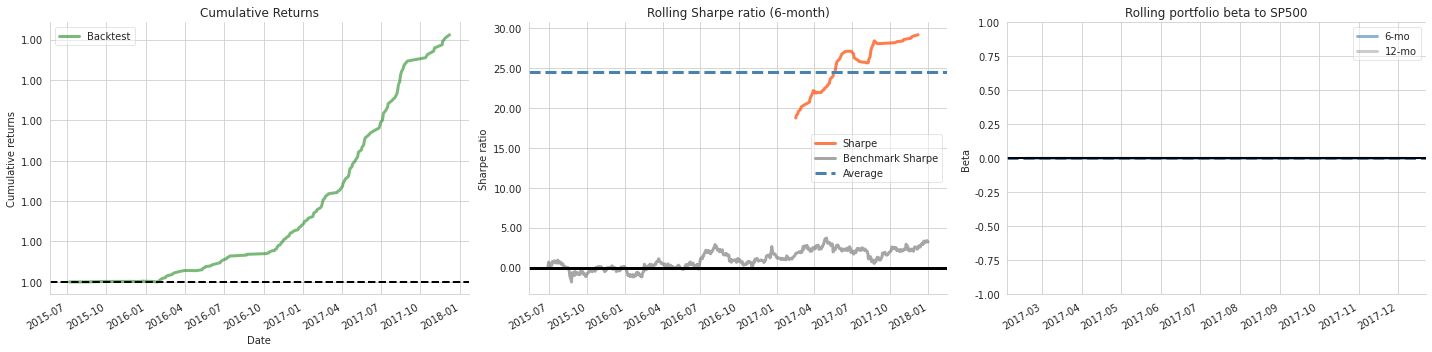

In [182]:
fig, axes = plt.subplots(ncols=3, figsize=(20,5))
pf.plotting.plot_rolling_returns( myStratRets, ax=axes[0])
axes[0].set_title('Cumulative Returns')
pf.plotting.plot_rolling_sharpe(myStratRets, benchmark,ax=axes[1])
pf.plotting.plot_rolling_beta(myStratRets, benchmark, ax=axes[2])
sns.despine()
fig.tight_layout();

### Create full tearsheet for overall and then for each

Start date,2015-07-07
End date,2017-12-08
Total months,9
,Backtest
Annual return,0.402%
Cumulative returns,0.306%
Annual volatility,0.022%
Sharpe ratio,18.45
Calmar ratio,424.16
Stability,0.88
Max drawdown,-0.001%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.00,2015-12-23,2016-01-25,2016-02-01,29
1,0.00,2016-04-08,2016-04-21,2016-05-11,24
2,0.00,2015-07-07,2015-07-24,2015-08-26,37
3,0.00,2015-11-02,2015-12-04,2015-12-22,37
4,0.00,2016-03-31,2016-04-06,2016-04-08,7


Stress Events,mean,min,max
Fall2015,0.00%,0.00%,0.00%
New Normal,0.00%,-0.00%,0.01%


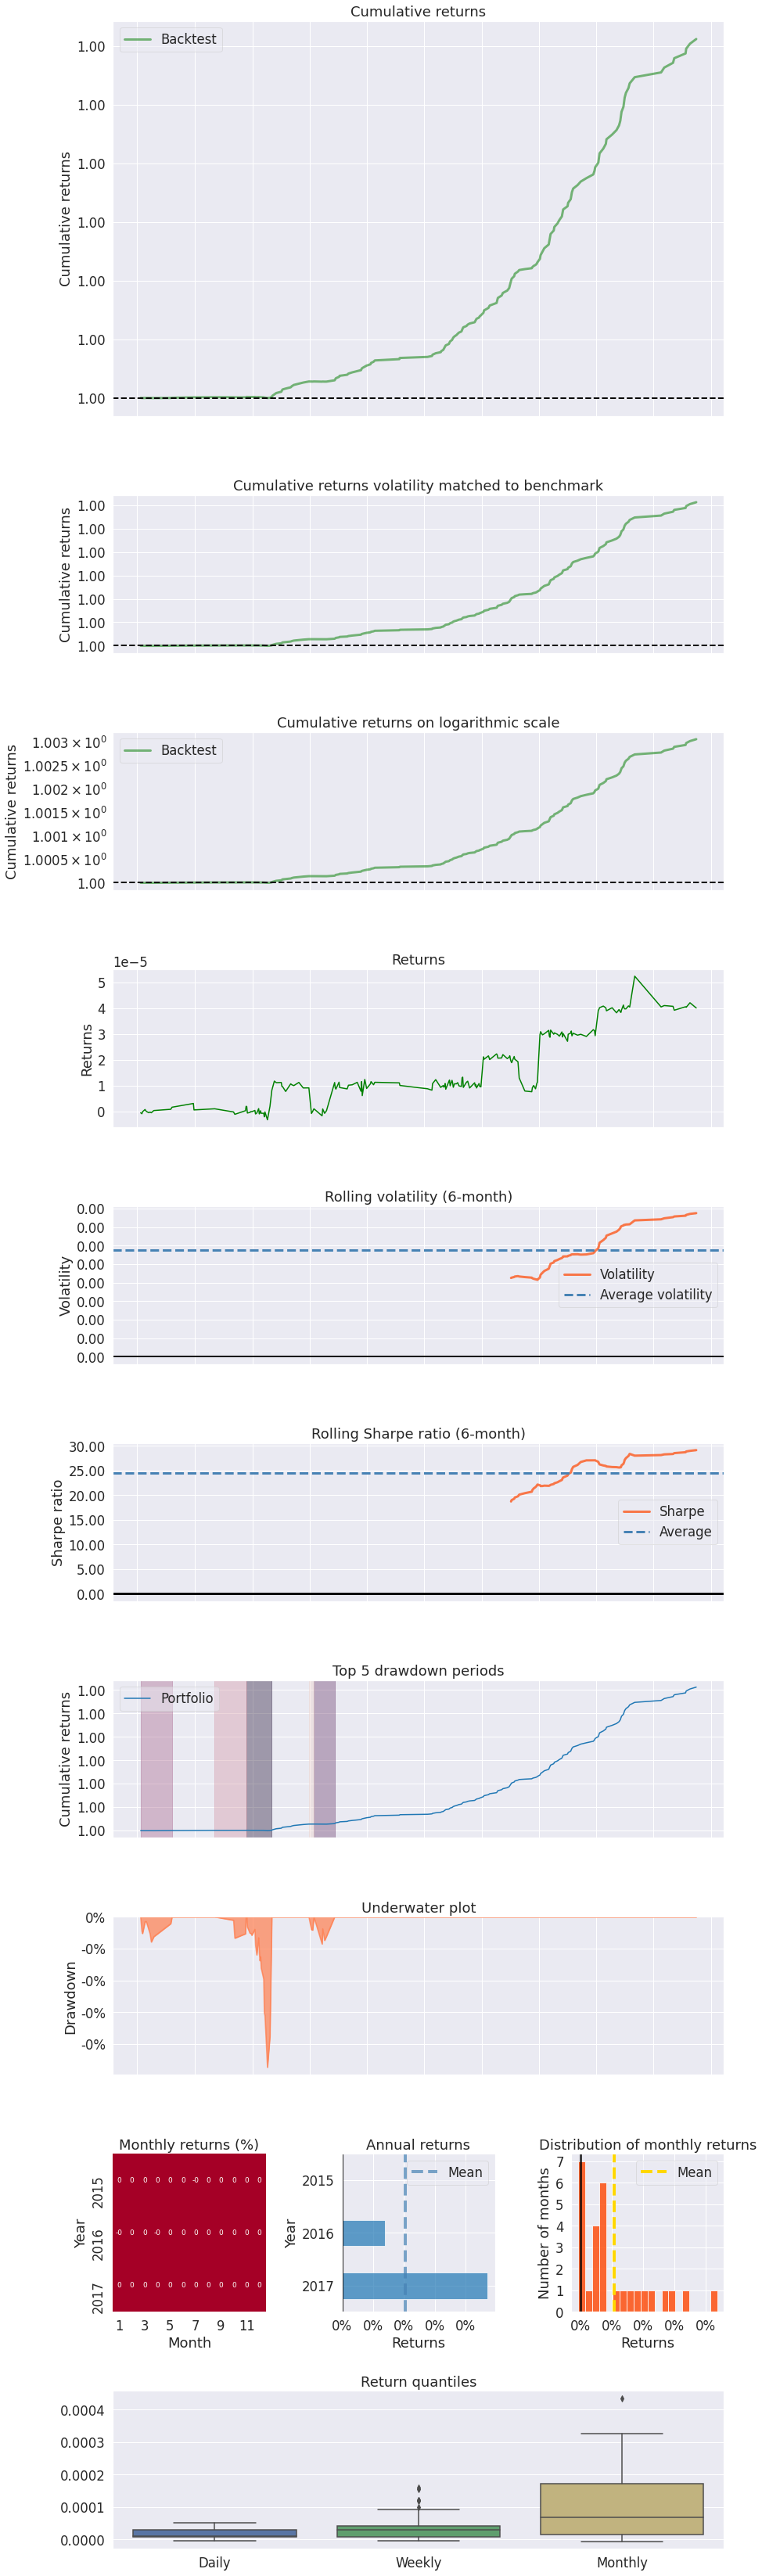

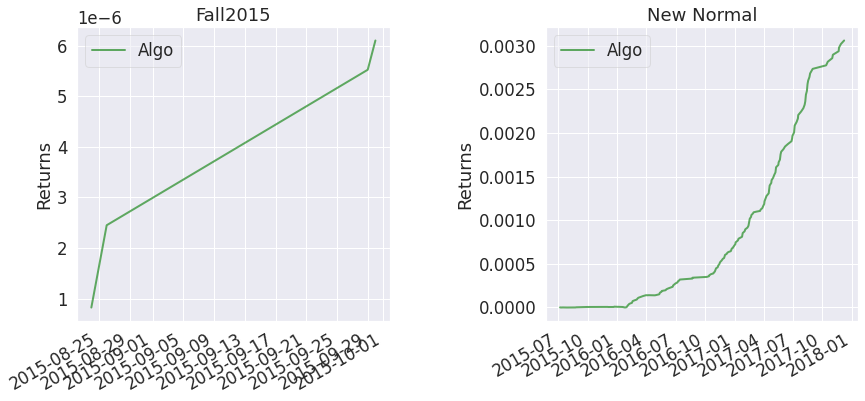

In [183]:
pf.create_full_tear_sheet(myStratRets,
                          estimate_intraday=False)

sma1


Start date,2015-07-07
End date,2017-12-08
Total months,9
,Backtest
Annual return,0.001%
Cumulative returns,0.0%
Annual volatility,0.0%
Sharpe ratio,1.48
Calmar ratio,2.28
Stability,0.52
Max drawdown,-0.0%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.00,2015-12-23,2016-11-04,2017-02-13,299
1,0.00,2017-05-09,2017-08-10,2017-11-03,129
2,0.00,2015-08-26,2015-09-29,2015-09-30,26
3,0.00,2015-11-02,2015-12-02,2015-12-04,25
4,0.00,2017-03-10,2017-03-21,2017-03-29,14


Stress Events,mean,min,max
Fall2015,0.00%,-0.00%,0.00%
New Normal,0.00%,-0.00%,0.00%


Mkt-RF


Start date,2015-07-07
End date,2017-12-08
Total months,9
,Backtest
Annual return,0.001%
Cumulative returns,0.001%
Annual volatility,0.001%
Sharpe ratio,1.30
Calmar ratio,1.34
Stability,0.49
Max drawdown,-0.001%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.00,2015-12-23,2016-06-24,2017-03-01,311
1,0.00,2015-07-16,2015-08-24,2015-09-30,55
2,0.00,2017-05-10,2017-08-10,2017-11-21,140
3,0.00,2017-03-10,2017-03-21,2017-04-20,30
4,0.00,2015-11-02,2015-12-02,2015-12-04,25


Stress Events,mean,min,max
Fall2015,0.00%,-0.00%,0.00%
New Normal,0.00%,-0.00%,0.00%


HML


Start date,2015-07-07
End date,2017-12-08
Total months,9
,Backtest
Annual return,0.001%
Cumulative returns,0.001%
Annual volatility,0.001%
Sharpe ratio,1.01
Calmar ratio,1.38
Stability,0.67
Max drawdown,-0.001%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.00,2015-07-09,2016-07-07,2016-11-10,351
1,0.00,2017-02-14,2017-06-16,NaT,NaN
2,0.00,2016-11-15,2016-11-16,2016-11-23,7
3,0.00,2016-12-22,2016-12-23,2017-01-03,9
4,0.00,2016-12-01,2016-12-02,2016-12-07,5


Stress Events,mean,min,max
Fall2015,-0.00%,-0.00%,0.00%
New Normal,0.00%,-0.00%,0.00%


RF


Start date,2015-07-07
End date,2017-12-08
Total months,9
,Backtest
Annual return,0.398%
Cumulative returns,0.303%
Annual volatility,0.022%
Sharpe ratio,18.38
Calmar ratio,NaN
Stability,0.87
Max drawdown,0.0%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.00,2015-07-07,2015-07-07,2015-07-07,1
1,NaN,NaT,NaT,NaT,NaN
2,NaN,NaT,NaT,NaT,NaN
3,NaN,NaT,NaT,NaT,NaN
4,NaN,NaT,NaT,NaT,NaN


Stress Events,mean,min,max
Fall2015,0.00%,0.00%,0.00%
New Normal,0.00%,0.00%,0.00%


MNA


Start date,2015-07-07
End date,2017-12-08
Total months,9
,Backtest
Annual return,0.001%
Cumulative returns,0.0%
Annual volatility,0.001%
Sharpe ratio,0.86
Calmar ratio,1.24
Stability,0.41
Max drawdown,-0.0%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.00,2015-12-23,2016-11-10,2017-04-04,335
1,0.00,2017-07-07,2017-08-10,NaT,NaN
2,0.00,2015-07-14,2015-07-24,2015-09-29,56
3,0.00,2017-05-23,2017-06-16,2017-07-07,34
4,0.00,2017-04-25,2017-05-04,2017-05-10,12


Stress Events,mean,min,max
Fall2015,0.00%,-0.00%,0.00%
New Normal,0.00%,-0.00%,0.00%


ICVT


Start date,2015-07-07
End date,2017-12-08
Total months,9
,Backtest
Annual return,0.0%
Cumulative returns,0.0%
Annual volatility,0.0%
Sharpe ratio,NaN
Calmar ratio,NaN
Stability,0.00
Max drawdown,0.0%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.00,2015-07-07,2015-07-07,2015-07-07,1
1,NaN,NaT,NaT,NaT,NaN
2,NaN,NaT,NaT,NaT,NaN
3,NaN,NaT,NaT,NaT,NaN
4,NaN,NaT,NaT,NaT,NaN


Stress Events,mean,min,max
Fall2015,0.00%,-0.00%,-0.00%
New Normal,0.00%,0.00%,0.00%


AQMNX


Start date,2015-07-07
End date,2017-12-08
Total months,9
,Backtest
Annual return,0.0%
Cumulative returns,0.0%
Annual volatility,0.001%
Sharpe ratio,0.02
Calmar ratio,0.01
Stability,0.54
Max drawdown,-0.001%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.00,2016-07-08,2017-08-11,NaT,NaN
1,0.00,2016-01-20,2016-03-07,2016-06-24,113
2,0.00,2015-12-02,2015-12-24,2016-01-15,33
3,0.00,2015-07-07,2015-07-10,2015-07-24,14
4,0.00,2015-09-29,2015-11-02,2015-12-02,47


Stress Events,mean,min,max
Fall2015,0.00%,-0.00%,0.00%
New Normal,0.00%,-0.00%,0.00%


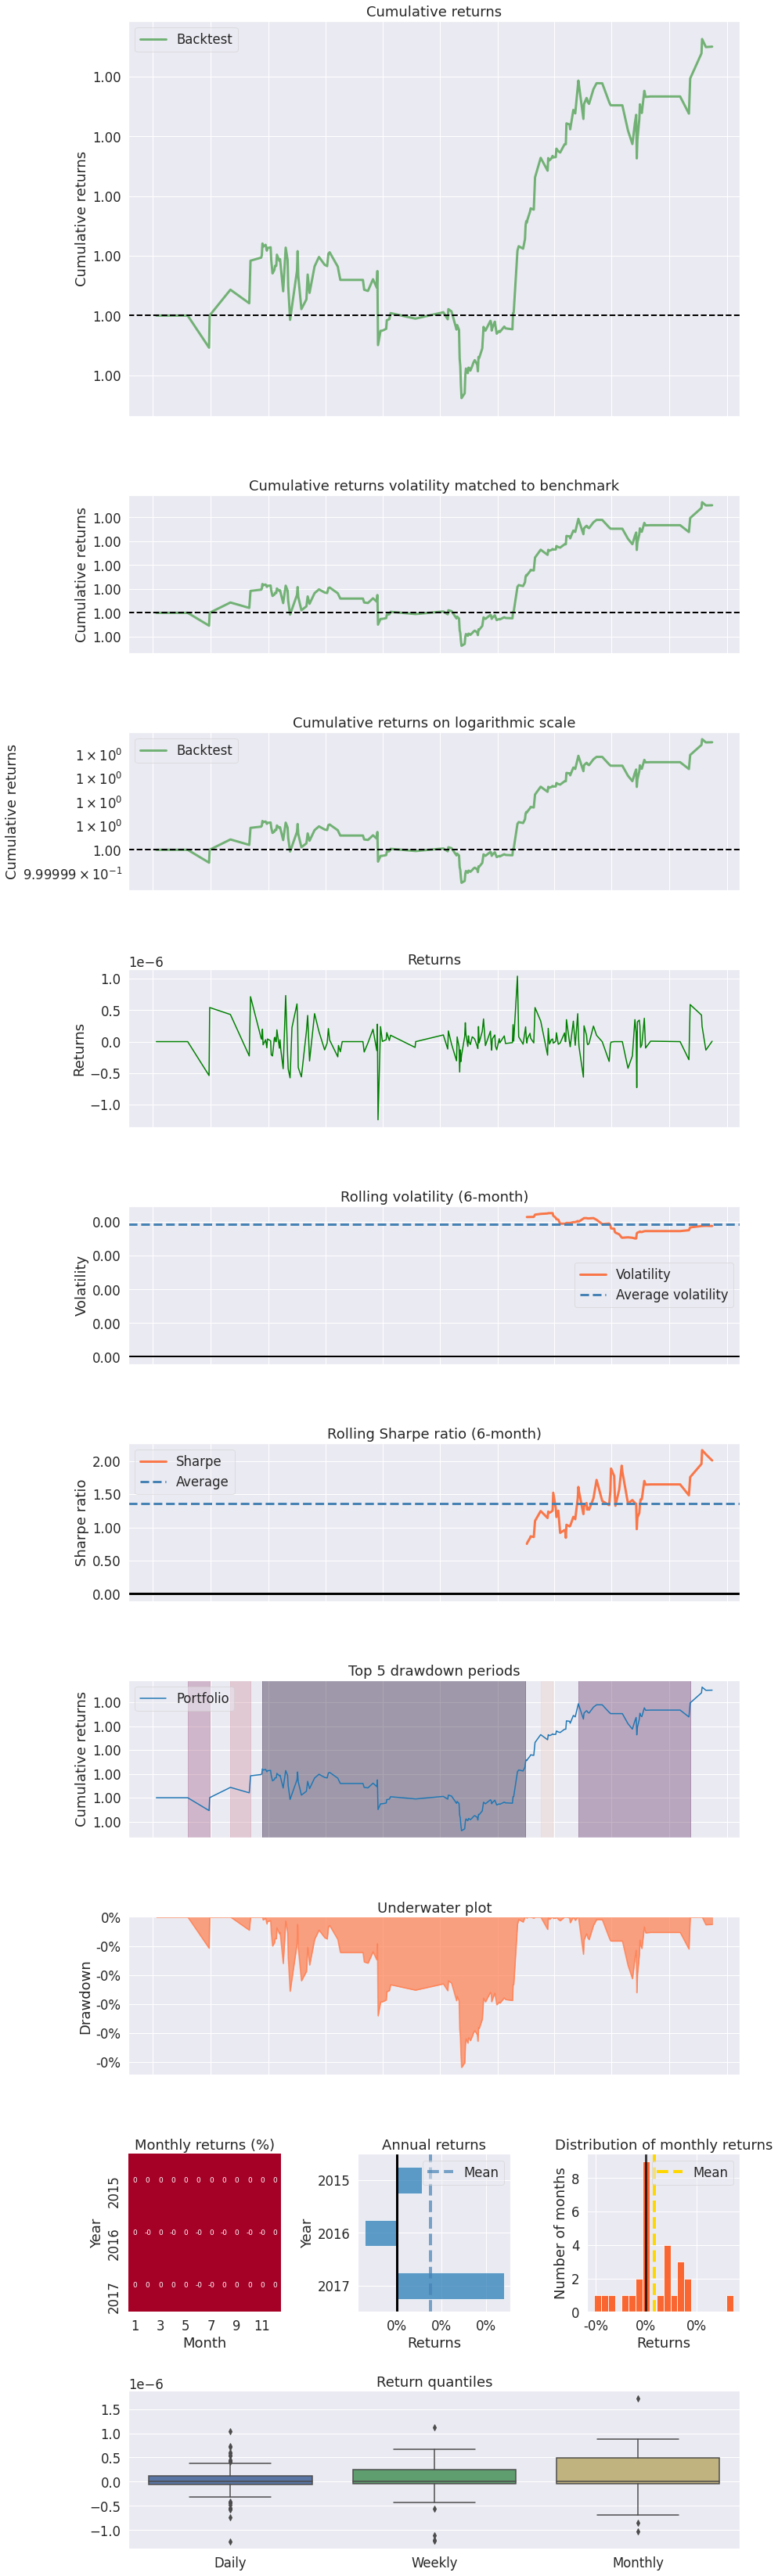

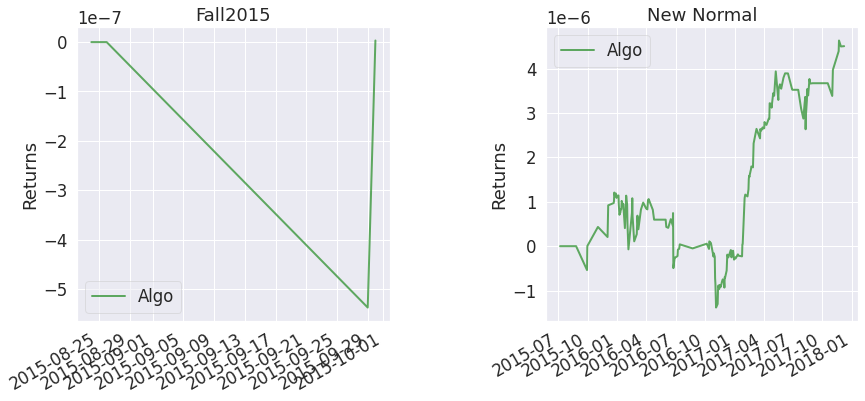

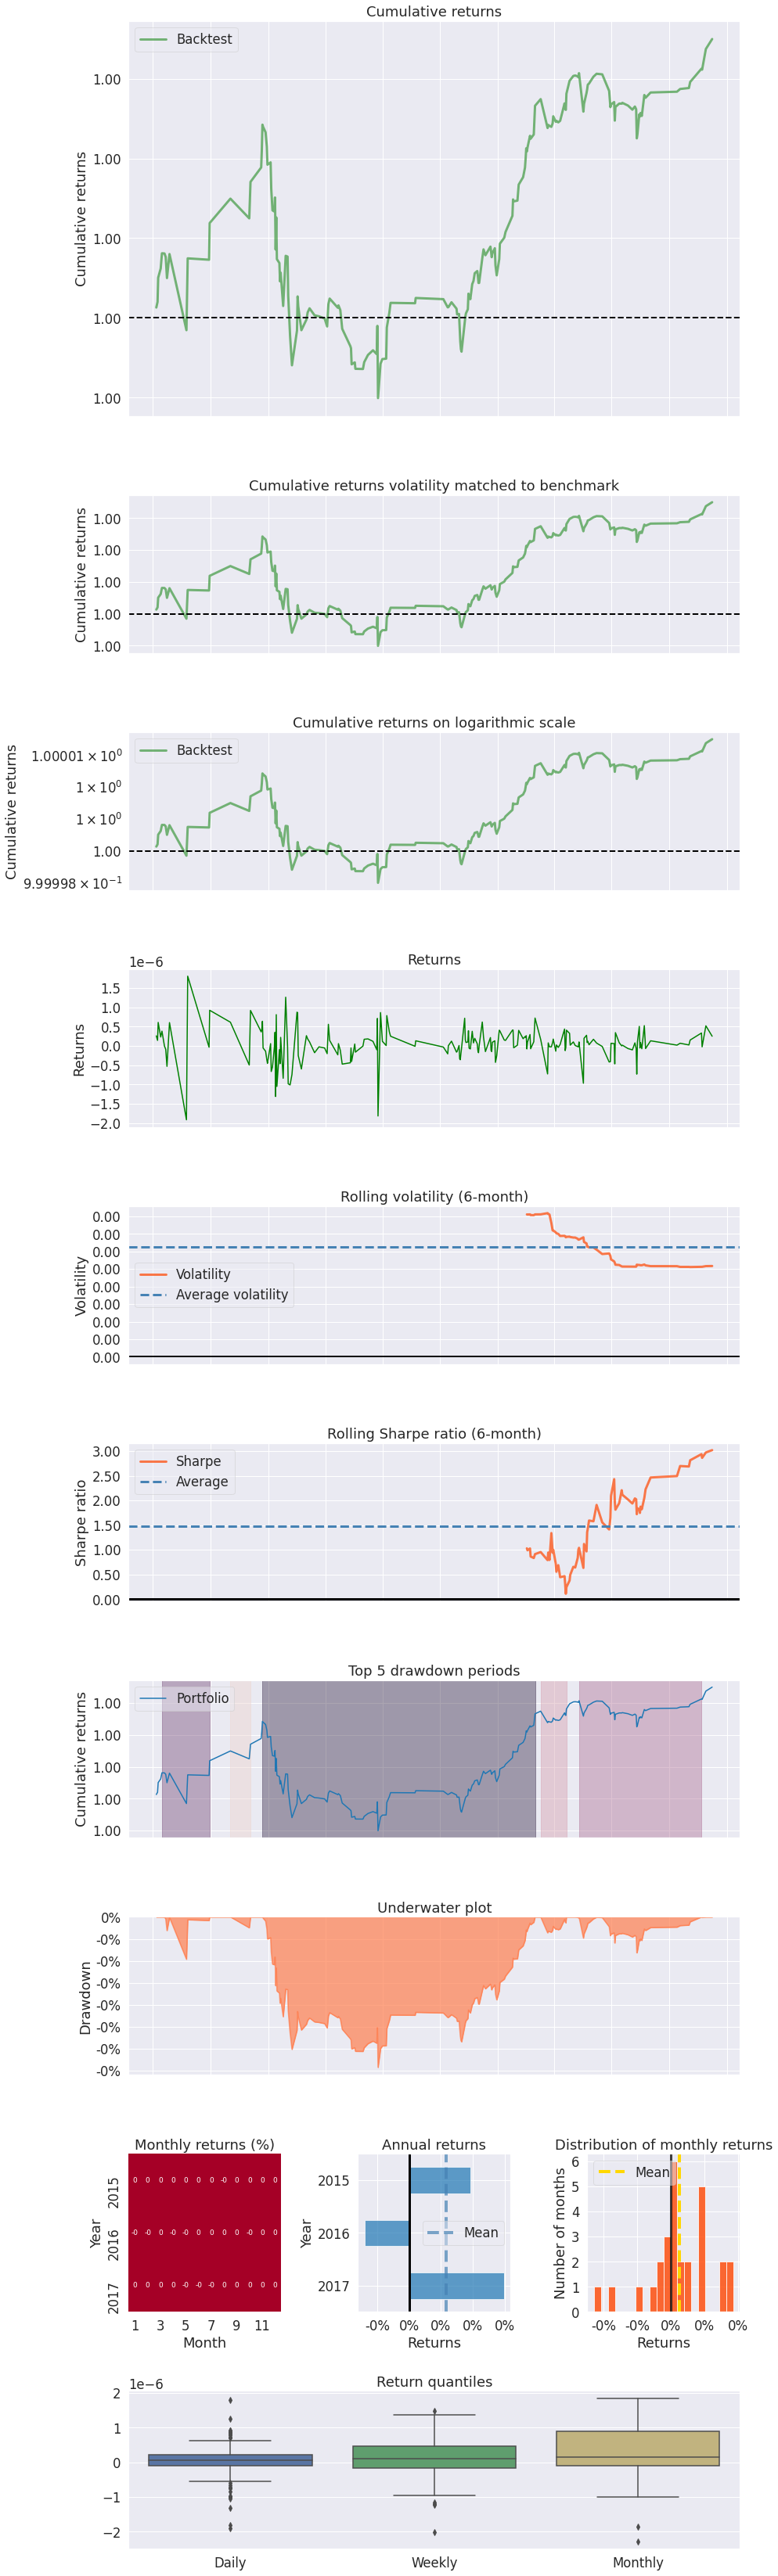

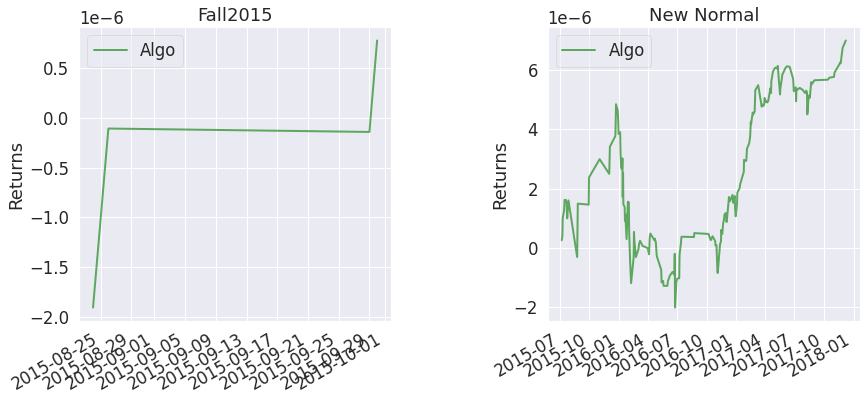

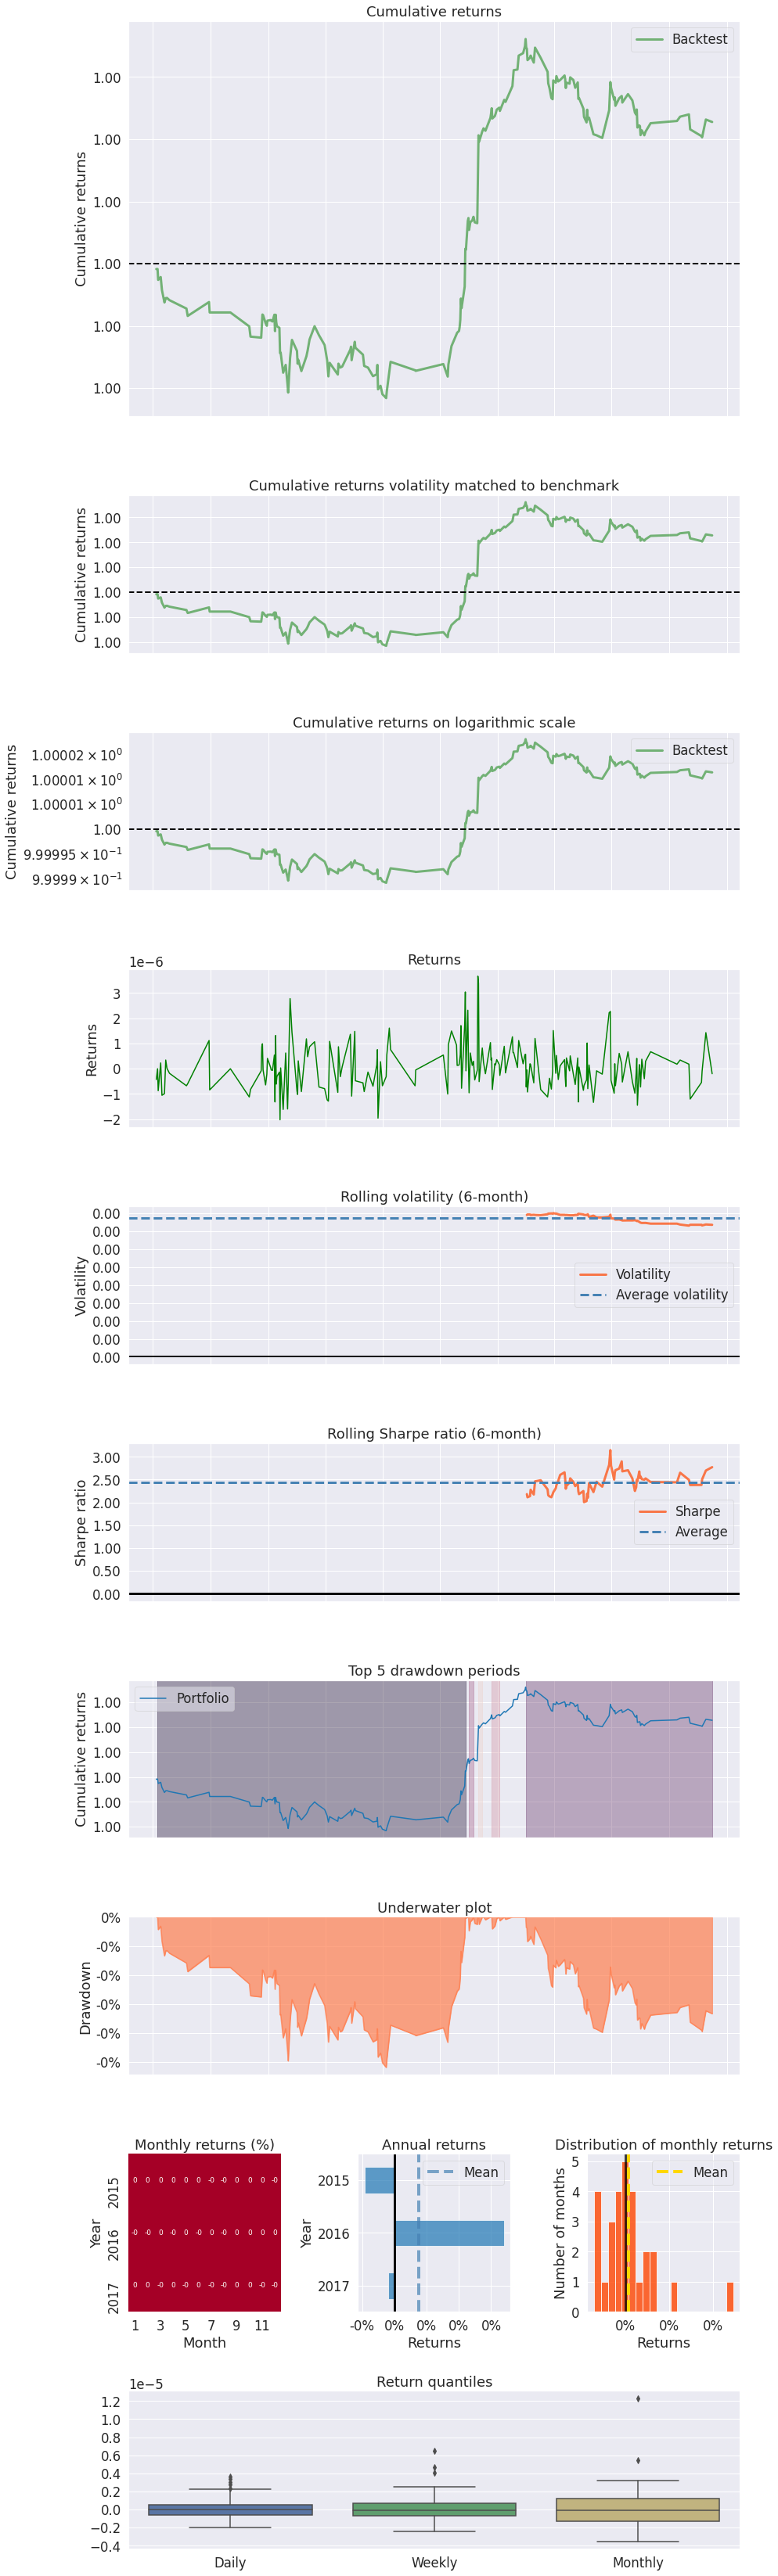

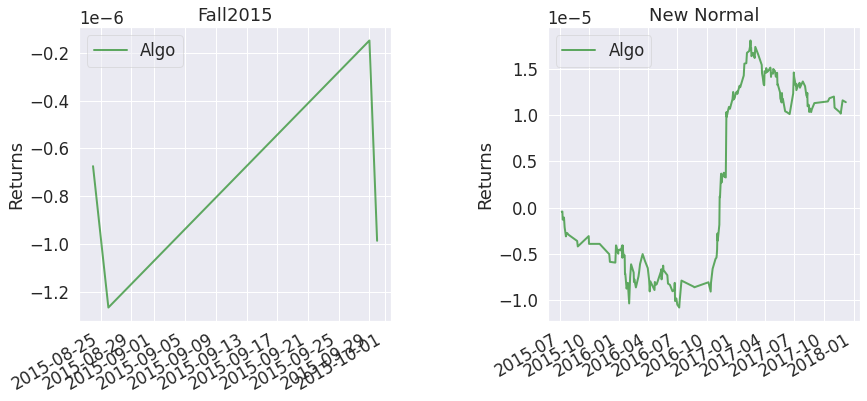

In [ ]:
for strat in strategies:
  print(strat)
  pf.create_full_tear_sheet(myStrat[strat],
                          estimate_intraday=False)